In [1]:
%pip install pandas numpy matplotlib

Note: you may need to restart the kernel to use updated packages.


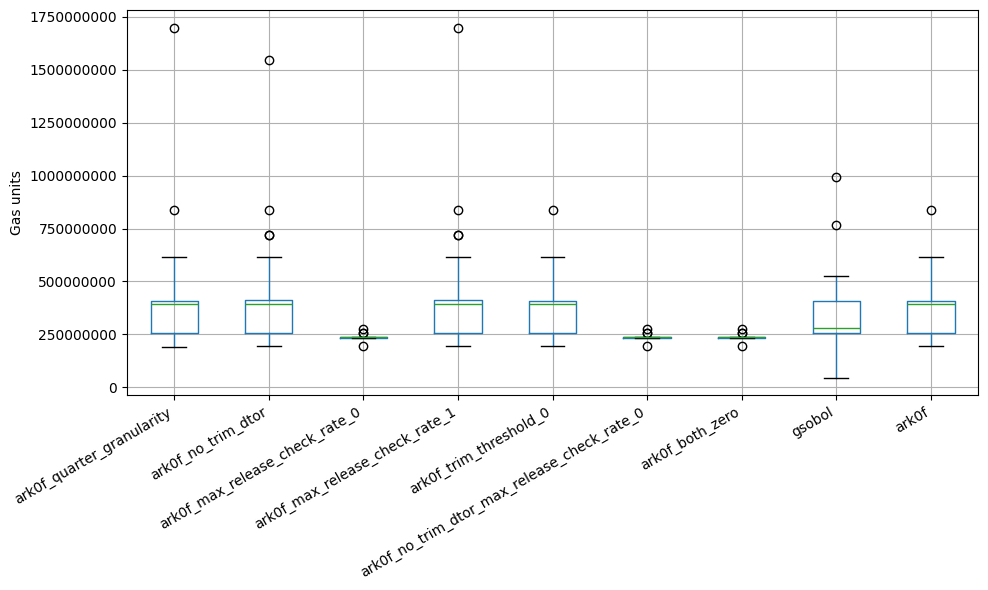

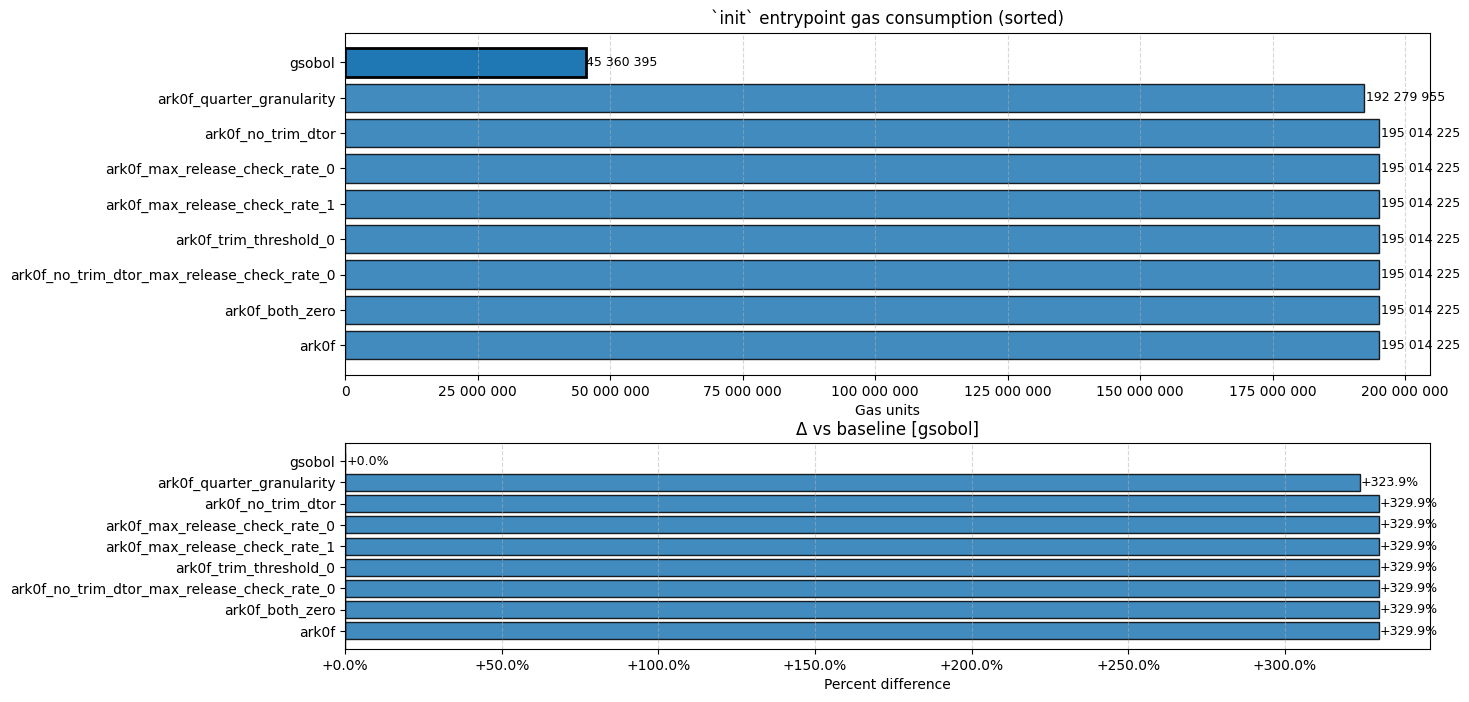

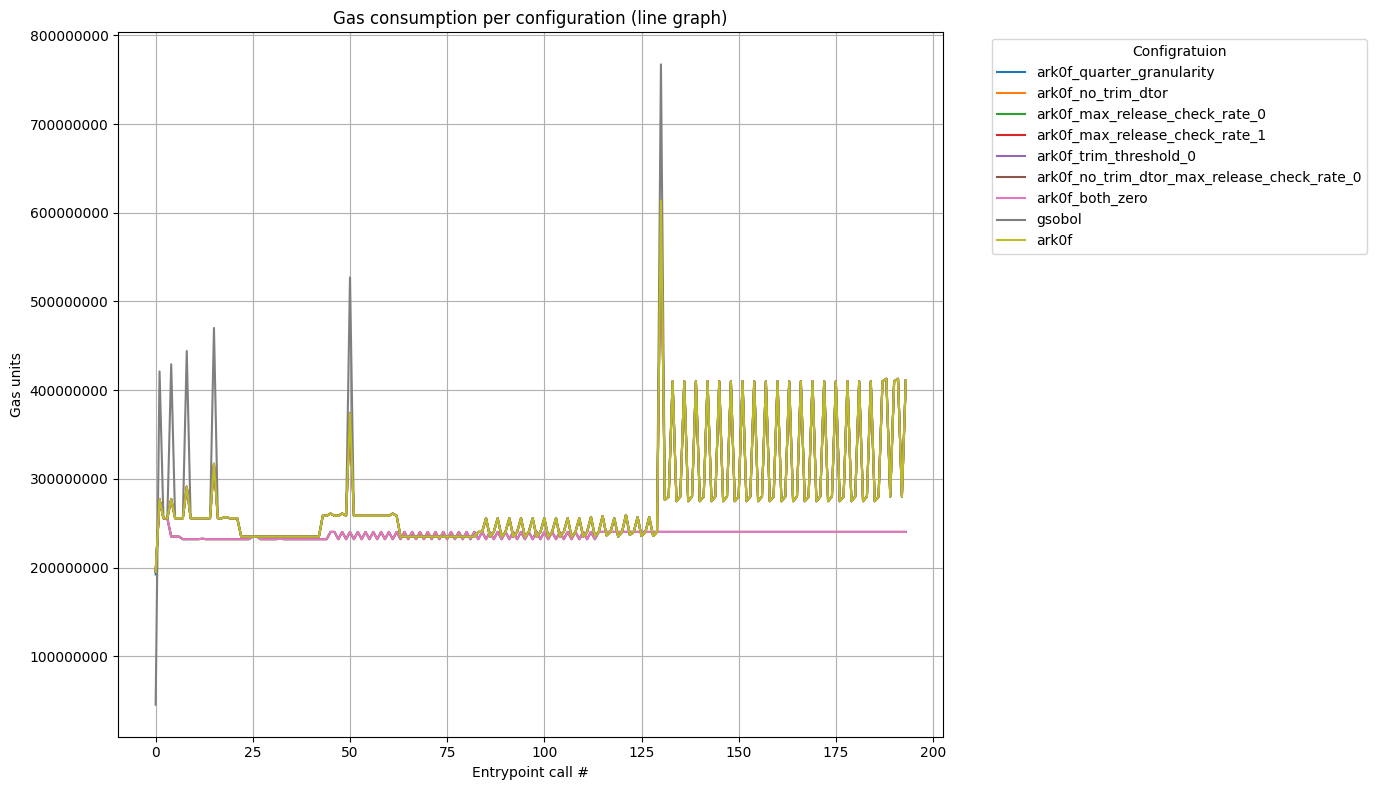

In [29]:
import os
import re
import glob
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter, FuncFormatter

files = glob.glob("results/*.log")
if not files:
    raise SystemExit("No files matched")

rx = re.compile(r"GAS SPENT:\s*([0-9]+)")
def extract_gas_numbers(path: str) -> list[int]:
    out = []
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        for line in f:
            m = rx.search(line)
            if m:
                out.append(int(m.group(1)))
    return out

names = [Path(f).stem for f in files]
prefix = os.path.commonprefix(names)
labels = [n[len(prefix):] for n in names]

data = {label: pd.Series(extract_gas_numbers(f), dtype="Int64") 
        for f, label in zip(files, labels)}

df = pd.DataFrame(data).dropna(axis=1, how="all")

def boxplot_graph():
    ax = df.boxplot(figsize=(10, 6), return_type="axes")
    ax.set_ylabel("Gas units")
    ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=False))
    ax.ticklabel_format(axis="y", style="plain")  # plain numbers, not 1e6
    plt.xticks(rotation=30, ha="right")
    plt.tight_layout()
    plt.savefig("boxplot.png", dpi=200)
    plt.show()

def init_entrypoint_graph():
    first_values = df.iloc[0]  # Series
    
    baseline_label = first_values.idxmin()
    baseline = first_values[baseline_label]
    
    # --- order by absolute value (ascending) ---
    vals = first_values.sort_values()
    labels = vals.index
    rel_pct = (vals / baseline - 1.0) * 100.0  # % vs baseline
    
    # formatters
    fmt_int = FuncFormatter(lambda x, _: f"{int(x):,}".replace(",", " "))
    fmt_pct = FuncFormatter(lambda x, _: f"{x:+.1f}%")
    
    fig, (ax1, ax2) = plt.subplots(
        2, 1, figsize=(14, 8),
        gridspec_kw={"height_ratios": [2.0, 1.2], "hspace": 0.25},
    )
    
    # ========== Absolute (gas units) ==========
    bars1 = ax1.barh(labels, vals.values, edgecolor="black", alpha=0.85)
    ax1.set_title("`init` entrypoint gas consumption (sorted)")
    ax1.set_xlabel("Gas units")
    ax1.xaxis.set_major_formatter(fmt_int)
    ax1.grid(axis="x", linestyle="--", alpha=0.5)
    ax1.invert_yaxis()  # smallest at top
    
    # annotate absolute values
    for b, v in zip(bars1, vals.values):
        ax1.text(b.get_width()*1.002, b.get_y()+b.get_height()/2,
                 f"{int(v):,}".replace(",", " "),
                 va="center", ha="left", fontsize=9)
    
    # highlight baseline bar
    for b, lab in zip(bars1, labels):
        if lab == baseline_label:
            b.set_alpha(1.0)
            b.set_linewidth(2.0)
            break
    
    # ========== Relative (% vs baseline) ==========
    bars2 = ax2.barh(labels, rel_pct.values, edgecolor="black", alpha=0.85)
    ax2.set_title(f"Δ vs baseline [{baseline_label}]")
    ax2.set_xlabel("Percent difference")
    ax2.xaxis.set_major_formatter(fmt_pct)
    ax2.grid(axis="x", linestyle="--", alpha=0.5)
    ax2.axvline(0, color="black", linewidth=1)
    ax2.invert_yaxis()
    
    # annotate % values
    for b, p in zip(bars2, rel_pct.values):
        ax2.text(b.get_width() + (0.4 if p >= 0 else -0.4),
                 b.get_y()+b.get_height()/2,
                 f"{p:+.1f}%",
                 va="center", ha="left" if p >= 0 else "right", fontsize=9)
    
    plt.savefig("init_entrypoint.png", dpi=200, bbox_inches="tight")
    plt.show()

def line_graph():
    min_len = df.notna().sum().min()
    df_first = df_nonempty.iloc[:min_len].copy()
    
    plt.figure(figsize=(14, 8))
    for col in df_first.columns:
        plt.plot(df_first.index, df_first[col], label=col)
    
    plt.title("Gas consumption per configuration (line graph)")
    plt.xlabel("Entrypoint call #")
    plt.ylabel("Gas units")
    plt.legend(title="File", loc="best")
    plt.grid(True)
    plt.ticklabel_format(axis="y", style="plain")
    plt.legend(title="Configratuion", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.savefig("line_graph.png", dpi=200)
    plt.show()

boxplot_graph()
init_entrypoint_graph()
line_graph()